__NOTE:__ currently users who only sent 1 message in the two minutes is included in calculation

## Outline

1. Background
    1. Current status
1. Algorithm 2: mean user activity rate
    1. Per 2 min chunk
        1. Mean user chat rate per chunk
            1. Interpretation
        1. Results
        1. Total chat rate per chunk
    1. Per hour (WIP)

# Background

__Description__:

1. Find the best moments in clips based on when rate of messages per user peaked. This involves answering the question "at which 2 min segment do the most users send the most messages?". If users X, Y, and Z all send 60% of their messages at timestamp range delta, then that timestamp might qualify as a "best moment"

__Datasets used__:

1. Big data `big_df`: 2409 rows representing one 7 hour 37 minute, 0 second twitch stream chat of [Hearthstone by LiiHS](https://www.twitch.tv/videos/955629991)
    * Used to create all algorithms

## Current status

__Finished:__
1. Algorithm 2
1. Graphing of preliminary results
1. Define user activity rate

__To do:__
~~1. Narrow down results to specific timestamps~~
~~1. Clean up helper functions to be more general~~
1. Write sanity checks
1. Finish per hour user activity rate for comparison

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import json

import matplotlib.pyplot as plt
import seaborn as sns

from pillaralgos.helpers import sanity_checks as s
from pillaralgos.helpers import data_handler as d
from pillaralgos.helpers import graph_helpers as g

# Algorithm 2: mean user activity rate

__Description__: Try to find the best moments in clips based on when rate of messages per user peaked

1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE
1. ~~Find overall message rate per 2 minutes per users~~ DONE
1. ~~Identify timestamps where `message_rate` peaked~~ DONE

Based on the above, it looks like top message sender sent the top message at all hours

In [2]:
data = json.load(open('data/big_data.json'))
big_df = d.organize_twitch_chat(data)

In [3]:
# split into hours
dfs = d.dfSplitter(big_df)
dfs.find_rest()
hour_list = dfs.result
first_stamp = hour_list[0]
del hour_list[0]

In [4]:
# label each dataset so we can tell what hour they came from
for i in range(len(hour_list)):
    hour_list[i]['hour'] = i

<ipython-input-4-580c10477d1c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hour_list[i]['hour'] = i


In [5]:
# split hours into 2 minute chunks
chunk_list = []
for hour in hour_list:
    xmc = d.xminChats(hour, big_df['_id'].unique(), min_=2) # split into 2 min segments
    xmc.find_rest()
    
    for chunk in xmc.result:
        chunk_list.append(chunk) # fmc.result gets returned as a list

In [6]:
def rate_finder(dataframe, hour, x=2):
    '''
    Finds the rate of messages sent per X minutes for each user in the dataframe.
    
    NOTE: if only 1 timestamp in chunk dataframe, assumes the chunk is exactly 2 minutes before the next chunk in the entire twitch chat stream
    '''
    # Initiate new df
    chat_rate_df = pd.DataFrame(columns = ['hour','chunk','time_start','time_end','_id','num_chats', f'chats_per_{x}min'])
    chatters = dataframe['_id'].unique() # id unique chatters for this chunk
    
    
    for i in range(len(chatters)):
        temp_df = dataframe[dataframe['_id']==chatters[i]] # isolate chatter's data
        hour = hour
        chunk = i
        time_start = dataframe.iloc[0,0]
        time_end = dataframe.iloc[-1,0]
        _id = chatters[i]
        num_chats = len(temp_df['body']) # count how many chats were sent by them
        time_d = dt.timedelta.total_seconds(dataframe.iloc[-1,0] - dataframe.iloc[0,0]) 

        if time_d > 0:
            chat_rate = (num_chats/time_d) * 60 * x # use time_d to calculate chat/sec, then multiply to get user requested rate
        elif time_d == 0:
            # if there is only 1 message in the chunk, there will be only 1 timestamp
            # in that case assume that time_d = 2
            time_d = 2
            chat_rate = (num_chats/time_d) * 60 * x # convert to chat/X minutes
        else:
            chat_rate = -100 # if number is negative, math is wrong somewhere and needs to be looked into

        # gather results
        results = pd.DataFrame({
            'hour':[hour],
            'chunk':[chunk],
            'time_start':[time_start],
            'time_end':[time_end],
            '_id':[_id],
            'num_chats':[num_chats],
            f'chats_per_{x}min':[chat_rate]
        })

        chat_rate_df = chat_rate_df.append(results) # store in df
    return chat_rate_df.reset_index(drop=True)
        

## Per chunk

### Mean user chat rate per chunk

In [7]:
chat_rates = pd.DataFrame(columns = ['hour', 'chunk', 'time_start', 'time_end', '_id', 'num_chats', 'chats_per_2min'])

# for each 2 min chunk
for chunk in chunk_list:
    hour = chunk.iloc[-1,12] # col 12 is hour.
    # find the chat rate for each user
    chat_rates = chat_rates.append(rate_finder(dataframe = chunk, hour = hour, x=2)) 
    
chat_rates = chat_rates.reset_index(drop=True)

__NOTE__: the below code was commented out. Readd if clips arent ideal.

```python
# eliminate rows where the user only chatted once (so the timedelta is 0)
deltas = []
for i, row in chat_rates.iterrows():
    delta = dt.timedelta.total_seconds(row['time_end'] - row['time_start'])
    deltas.append(delta)

chat_rates['elapsed'] = deltas # this was only done so we can filter out the 0s
chat_rates = chat_rates[chat_rates['elapsed'] != 0]
# replace with actual datetime
chat_rates['elapsed'] = chat_rates['time_end'] - chat_rates['time_start']
```

Text(0.5, -0.15, 'One dot represents one user')

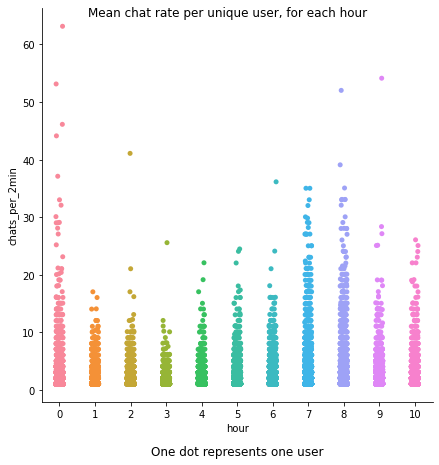

In [8]:
sns.catplot(x='hour',y='chats_per_2min', data=chat_rates, kind = 'strip',height=6)
plt.suptitle("Mean chat rate per unique user, for each hour",y=0.98)
plt.title("One dot represents one user",y=-0.15)

#### Interpretation

There were three chunks (at hours 2,6,7 respectively) where mean unique user chat rate was higher than anywhere else. Let's isolate the top 3 most active hours

NOTE: below function saved into `graph_helpers.py`

In [36]:
def plot_with_time(x,y,data, xformat='%H:%m'):
    '''
    Plots a scatterplot with the xaxis neatly formatted
    
    input
    -----
    x: str
        Column name. Column must be datetime
    y: str
    data: pd.DataFrame
    xformat: str
        Format xaxis should be displayed in, using strftime syntax
    '''
    import matplotlib.dates as mdates
    fig, ax = plt.subplots()
    sns.scatterplot(x=x,y=y,data=data)
    
    myFmt = mdates.DateFormatter(xformat)
    ax.xaxis.set_major_formatter(myFmt)


Text(0.5, 1.0, 'One dot is the chat rate of one user')

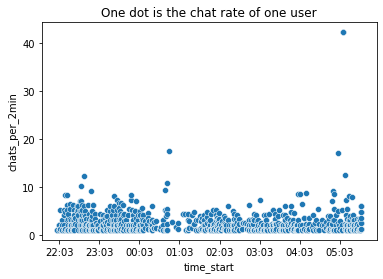

In [37]:
g.plot_with_time(x='time_start',y='chats_per_2min',data=chat_rates)
plt.title('One dot is the chat rate of one user')

### Result

In [9]:
chat_rates.sort_values('chats_per_2min', ascending=False).head()

,hour,chunk,time_start,time_end,_id,num_chats,chats_per_2min
493,2,0,2021-03-20 00:51:36.669000+00:00,2021-03-20 00:51:36.669000+00:00,114595489,1,60.000000
490,2,0,2021-03-20 00:46:19.178000+00:00,2021-03-20 00:46:19.178000+00:00,105281444,1,60.000000
498,3,0,2021-03-20 01:01:21.955000+00:00,2021-03-20 01:01:21.955000+00:00,189946743,1,60.000000
1127,7,0,2021-03-20 05:04:52.155000+00:00,2021-03-20 05:04:54.993000+00:00,488814751,1,42.283298
1128,7,1,2021-03-20 05:04:52.155000+00:00,2021-03-20 05:04:54.993000+00:00,479407171,1,42.283298


In [10]:
result = chat_rates.groupby(['time_start','time_end']).mean().reset_index()
result = result.sort_values('chats_per_2min', ascending=False)
result.columns = ['start','end','chats_per_2min']
result.head()

,start,end,chats_per_2min
81,2021-03-20 01:01:21.955000+00:00,2021-03-20 01:01:21.955000+00:00,60.000000
78,2021-03-20 00:51:36.669000+00:00,2021-03-20 00:51:36.669000+00:00,60.000000
76,2021-03-20 00:46:19.178000+00:00,2021-03-20 00:46:19.178000+00:00,60.000000
183,2021-03-20 05:04:52.155000+00:00,2021-03-20 05:04:54.993000+00:00,42.283298
75,2021-03-20 00:44:05.361000+00:00,2021-03-20 00:44:32.755000+00:00,17.522085


Text(0.5, 1.0, 'Mean user chat rate per 2min chunk')

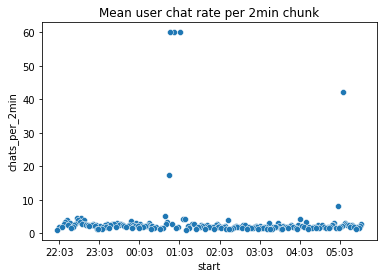

In [11]:
g.plot_with_time(x='start',y='chats_per_2min',data=result)
plt.title("Mean user chat rate per 2min chunk")

In [44]:
d.save_json(d.results_jsonified(result,first_stamp, 'chats_per_2min'), 'algo2_mean_rate_per_2min')

Saved to data/algo2_mean_rate_per_2min.json


### Total chat rate per chunk

In [9]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103873 entries, 0 to 103872
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   created_at    103873 non-null  datetime64[ns, UTC]
 1   updated_at    103873 non-null  datetime64[ns, UTC]
 2   display_name  103873 non-null  object             
 3   _id           103873 non-null  object             
 4   name          103873 non-null  object             
 5   type          103873 non-null  object             
 6   bio           26014 non-null   object             
 7   logo          103873 non-null  object             
 8   body          103873 non-null  object             
 9   is_action     103873 non-null  bool               
 10  user_badges   44011 non-null   object             
 11  emoticons     11928 non-null   object             
dtypes: bool(1), datetime64[ns, UTC](2), object(9)
memory usage: 8.8+ MB


In [12]:
big_df = big_df.astype({
    'display_name':'category',
    '_id':int,
    'name':'category',
})

In [13]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103873 entries, 0 to 103872
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   created_at    103873 non-null  datetime64[ns, UTC]
 1   updated_at    103873 non-null  datetime64[ns, UTC]
 2   display_name  103873 non-null  category           
 3   _id           103873 non-null  int64              
 4   name          103873 non-null  category           
 5   type          103873 non-null  object             
 6   bio           26014 non-null   object             
 7   logo          103873 non-null  object             
 8   body          103873 non-null  object             
 9   is_action     103873 non-null  bool               
 10  user_badges   44011 non-null   object             
 11  emoticons     11928 non-null   object             
dtypes: bool(1), category(2), datetime64[ns, UTC](2), int64(1), object(6)
memory usage: 8.3+ MB


In [18]:
def big_rate_finder(dataframe, x=2):
    '''
    Finds the overall chat rate per X minutes, regardless of chatter ID
    '''
    
    dataframe = dataframe.sort_values('created_at')
    seconds = dt.timedelta.total_seconds(dataframe.iloc[-1,0] - dataframe.iloc[0,0])
    messages = len(dataframe['body'])
    
    if seconds != 0:
        rate = (messages/seconds) * 60 * x
    else:
        rate = (messages/120) * 60 * x
    
    return rate

In [19]:
chunk_rates = {}
for i in range(len(chunk_list)):
    rate = big_rate_finder(chunk_list[i])
    chunk_rates[i] = [rate]

In [20]:
chunk_rates = pd.DataFrame(chunk_rates).T.reset_index()
chunk_rates.columns = ['chunk','chat_per_2min']

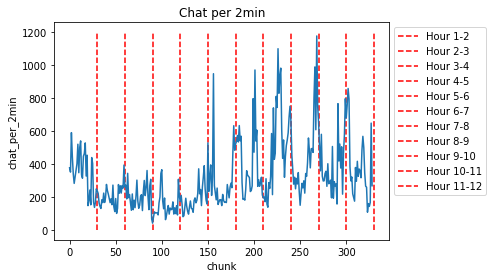

In [24]:
sns.lineplot(x='chunk',y='chat_per_2min',data=chunk_rates)
plt.title("Chat per 2min")
x=0
for i in range(29,350):
    if i % 30 == 0:
        x+=1
        plt.vlines(i, ymin=0, ymax=1200, colors='red',linestyles='--',label=f'Hour {x}-{x+1}')
plt.legend(bbox_to_anchor=(1,1))

## Per hour

In [25]:
hour_rates = {}
for i in range(len(hour_list)):
    rate = big_rate_finder(hour_list[i])
    hour_rates[i] = [rate]

In [26]:
hour_rates = pd.DataFrame(hour_rates).T.reset_index()
hour_rates.columns = ['hour','chat_per_2min']

Text(0.5, 1.0, 'Chat per 2min')

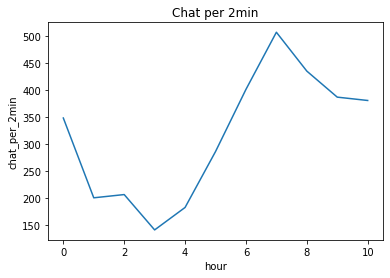

In [27]:
sns.lineplot(x='hour',y='chat_per_2min',data=hour_rates)
plt.title("Chat per 2min")

__Interpretation__: Hours 0,1,7 had the most chat activity overall. 